In [1]:
#Importing Dependencies-3.1
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#Importing tensorflow dependencies Functional API-3.1
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer , Conv2D, Dense,MaxPooling2D,Input,Flatten


In [3]:
#Avoiding OOM(Out of Memory) error by limiting GPU memory growth-3.2
gpus=tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [4]:
# Setup paths-3.3
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# Import uuid library to generate unique image names
import uuid

In [6]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\3c9fa992-1891-11ef-93f9-a006a3854c01.jpg'

In [7]:
# Establish a connection to the webcam-4.1, Image capturing loop 4.2
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
    
# Cut down frame to  250px  to 250px- 4.3
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchor images-4.4
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives-4.4
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
        
    
    # Show image back to screen-4.5
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

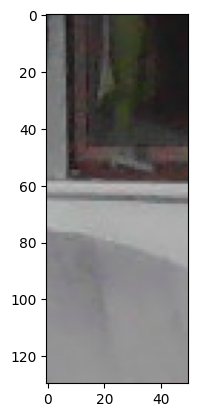

In [8]:
plt.imshow(frame[120:120+250,200:200+250, :])  

In [9]:
anchor=tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(100)
positive=tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(100)
negative=tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(100)

In [10]:
dir_test=anchor.as_numpy_iterator()

In [11]:
print(dir_test.next())

b'data\\anchor\\64fe9771-e260-11ee-93fa-f077c3eb5211.jpg'


In [12]:
 def preprocess(file_path):
    
    # Read images from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    #Resizing the image to be 105x105x3
    img = tf.image.resize(img, (105,105))
    
    #Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [13]:
img =preprocess('data\\anchor\\64443f12-e260-11ee-922b-f077c3eb5211.jpg')

In [14]:
img.numpy().max() 

0.9333674

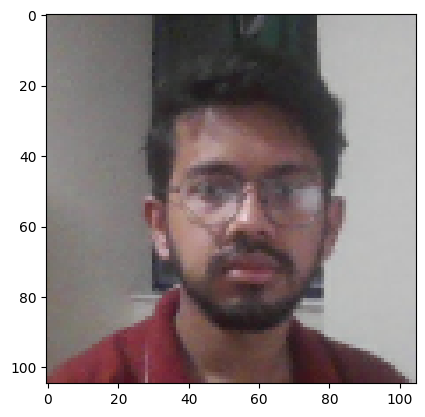

In [15]:
plt.imshow(img)

In [16]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)


In [17]:
samples = data.as_numpy_iterator()

In [18]:
example = samples.next()

In [19]:
example

(b'data\\anchor\\654e755a-e260-11ee-ba6f-f077c3eb5211.jpg',
 b'data\\positive\\464e30e1-e260-11ee-a933-f077c3eb5211.jpg',
 1.0)

In [20]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [21]:
res = preprocess_twin(*example)

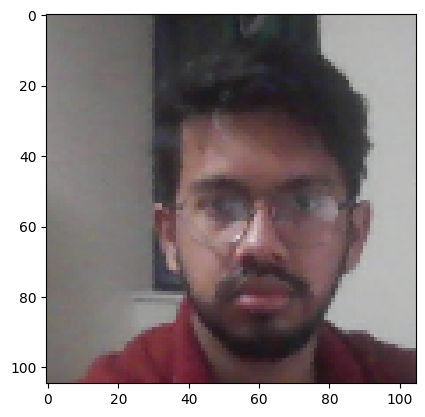

In [22]:
plt.imshow(res[1])

In [23]:
round(len(data)*.7)

140

In [24]:
# Building dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [25]:
# Training partition-70%
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [26]:
# Testing partition-30%
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [27]:
inp=Input(shape=(105,105,3),name='input_image')

In [28]:
c1=Conv2D(64,(10,10),activation='relu')(inp)
m1=MaxPooling2D(64,(2,2),padding='same')(c1)

In [29]:
c2=Conv2D(128,(7,7),activation='relu')(m1)
m2=MaxPooling2D(64,(2,2),padding='same')(c2)

In [30]:
c3=Conv2D(128,(4,4),activation='relu')(m2)
m3=MaxPooling2D(64,(2,2),padding='same')(c3)

In [31]:
c4=Conv2D(256,(4,4),activation='relu')(m3)
f1=Flatten()(c4)
d1=Dense(4096,activation='sigmoid')(f1)

In [32]:
mod=Model(inputs=[inp],outputs=[d1],name='embedding')

In [33]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 48, 48, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 128)       26

In [34]:
def make_embedding():
    inp=Input(shape=(105,105,3),name='input_image')

    #First Layer
    c1=Conv2D(64,(10,10),activation='relu')(inp)
    m1=MaxPooling2D(64,(2,2),padding='same')(c1)

    #Second Layer
    c2=Conv2D(128,(7,7),activation='relu')(m1)
    m2=MaxPooling2D(64,(2,2),padding='same')(c2)

    #third layer
    c3=Conv2D(128,(4,4),activation='relu')(m2)
    m3=MaxPooling2D(64,(2,2),padding='same')(c3)

    #final layer
    c4=Conv2D(256,(4,4),activation='relu')(m3)
    f1=Flatten()(c4)
    d1=Dense(4096,activation='sigmoid')(f1)
    
    return Model(inputs=[inp],outputs=[d1],name='embedding')

In [35]:
embedding=make_embedding()

In [36]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 18, 18, 128)       26

In [37]:
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    #Calculating similarity
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [38]:
l1 = L1Dist()

In [39]:
input_image = Input(name='input_img', shape=(105,105,3))
validation_image = Input(name='validation_img', shape=(105,105,3))

In [40]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [41]:
siamese_layer = L1Dist()

In [42]:
distances = siamese_layer(inp_embedding, val_embedding)

In [43]:
classifier = Dense(1, activation='sigmoid')(distances)

In [44]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [45]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [46]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [47]:
def make_siamese_model(): 
    
    #Inputing ancgor image in the network
    input_image = Input(name='input_img', shape=(105,105,3))
    
    # Inputting Validation image in the network 
    validation_image = Input(name='validation_img', shape=(105,105,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [48]:
siamese_model = make_siamese_model()

In [49]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [50]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [51]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [52]:
#Estabilishing checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [53]:
test_batch = train_data.as_numpy_iterator()

In [54]:
batch_1 = test_batch.next()

In [55]:
X = batch_1[:2]

In [56]:
y = batch_1[2]

In [57]:
y

array([1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0.],
      dtype=float32)

In [58]:
tf.losses.BinaryCrossentropy

keras.losses.BinaryCrossentropy

In [59]:
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss  

In [60]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [61]:
EPOCHS=50

In [62]:
train(train_data,EPOCHS)


 Epoch 1/50
tf.Tensor(0.696846, shape=(), dtype=float32)
9/9 [==============================] - 392s 43s/step

 Epoch 2/50
tf.Tensor(0.42128903, shape=(), dtype=float32)
9/9 [==============================] - 402s 44s/step

 Epoch 3/50
tf.Tensor(0.3986421, shape=(), dtype=float32)
9/9 [==============================] - 381s 42s/step

 Epoch 4/50
tf.Tensor(0.34209466, shape=(), dtype=float32)
9/9 [==============================] - 384s 43s/step

 Epoch 5/50
tf.Tensor(0.28435606, shape=(), dtype=float32)
9/9 [==============================] - 372s 41s/step

 Epoch 6/50
tf.Tensor(0.10252079, shape=(), dtype=float32)
9/9 [==============================] - 370s 41s/step

 Epoch 7/50
tf.Tensor(0.17370974, shape=(), dtype=float32)
9/9 [==============================] - 374s 41s/step

 Epoch 8/50
tf.Tensor(0.038299, shape=(), dtype=float32)
9/9 [==============================] - 397s 44s/step

 Epoch 9/50
tf.Tensor(0.0258286, shape=(), dtype=float32)
9/9 [==============================] - 394

In [63]:
from tensorflow.keras.metrics import Precision, Recall

In [64]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [65]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[9.9945188e-01],
       [7.8619225e-05],
       [2.4155909e-07],
       [1.0000000e+00],
       [9.9998903e-01],
       [8.2013978e-09],
       [1.1377372e-08],
       [4.8717141e-07],
       [9.9997741e-01],
       [9.9999899e-01],
       [9.9999976e-01],
       [9.9999589e-01],
       [1.0813263e-05],
       [8.6995959e-04],
       [9.9998987e-01],
       [2.6532958e-09]], dtype=float32)

In [66]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0]

In [67]:
y_true

array([1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0.],
      dtype=float32)

In [68]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [69]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [ ]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()


In [71]:
siamese_model.save('siamesemodel.h5')

In [72]:
L1Dist

__main__.L1Dist

In [73]:
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [74]:
model.predict([test_input, test_val])

array([[9.9945188e-01],
       [7.8619225e-05],
       [2.4155909e-07],
       [1.0000000e+00],
       [9.9998903e-01],
       [8.2013978e-09],
       [1.1377372e-08],
       [4.8717141e-07],
       [9.9997741e-01],
       [9.9999899e-01],
       [9.9999976e-01],
       [9.9999589e-01],
       [1.0813263e-05],
       [8.6995959e-04],
       [9.9998987e-01],
       [2.6532958e-09]], dtype=float32)

In [75]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [105]:
def verify (model, detection_threshold, verification_threshold):
    # Building results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_image')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_image', image))
        
        # Making Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_image'))) 
    verified = verification > verification_threshold
    
    return results, verified
 

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0XFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

False
False
False
